In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from learnMSA.msa_hmm import (Align, Clustering, Configuration, Initializers,
                              Visualize)
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2025-05-09 20:40:06.121544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 20:40:06.137542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 20:40:06.142446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746816007.292889 1068576 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746816007.333470 1068576 cuda_executor.cc:1015] succ

In [2]:
name = "3_1000"
suffix = "_short"

# unaligned sequences
train_filename = f"../trees/data/dev_msa/{name}{suffix}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/data/dev_trees/{name}.nwk"

# number of distinct pHMMs
num_models = 5

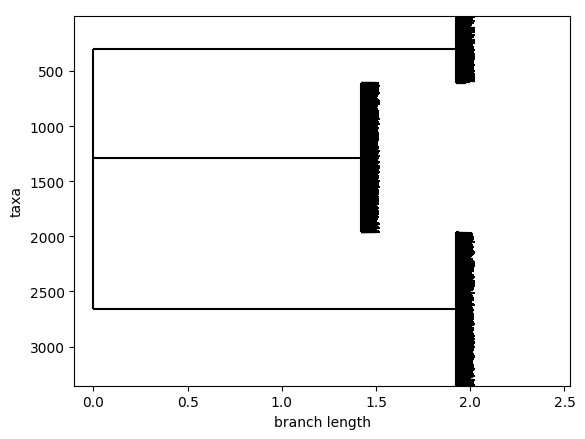

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

In [4]:
out_filename = "test/data/star_default.fasta"

In [5]:

config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    # config["len_mul"] = 1.0
    # config["length_init_quantile"] = 0.5
    # config["max_surgery_runs"] = 1
    seq_weights = Clustering.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"])
    alignment_model = Align.run_learnMSA(
        data,
        out_filename,
        config, 
        sequence_weights=seq_weights,
        verbose=True,
        align_insertions=True,
        A2M_output=False #requires to run FastSP
    )

Training of 5 models on file 3_1000_short.unaligned.fa
Configuration: 
{
num_models : 5
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, al

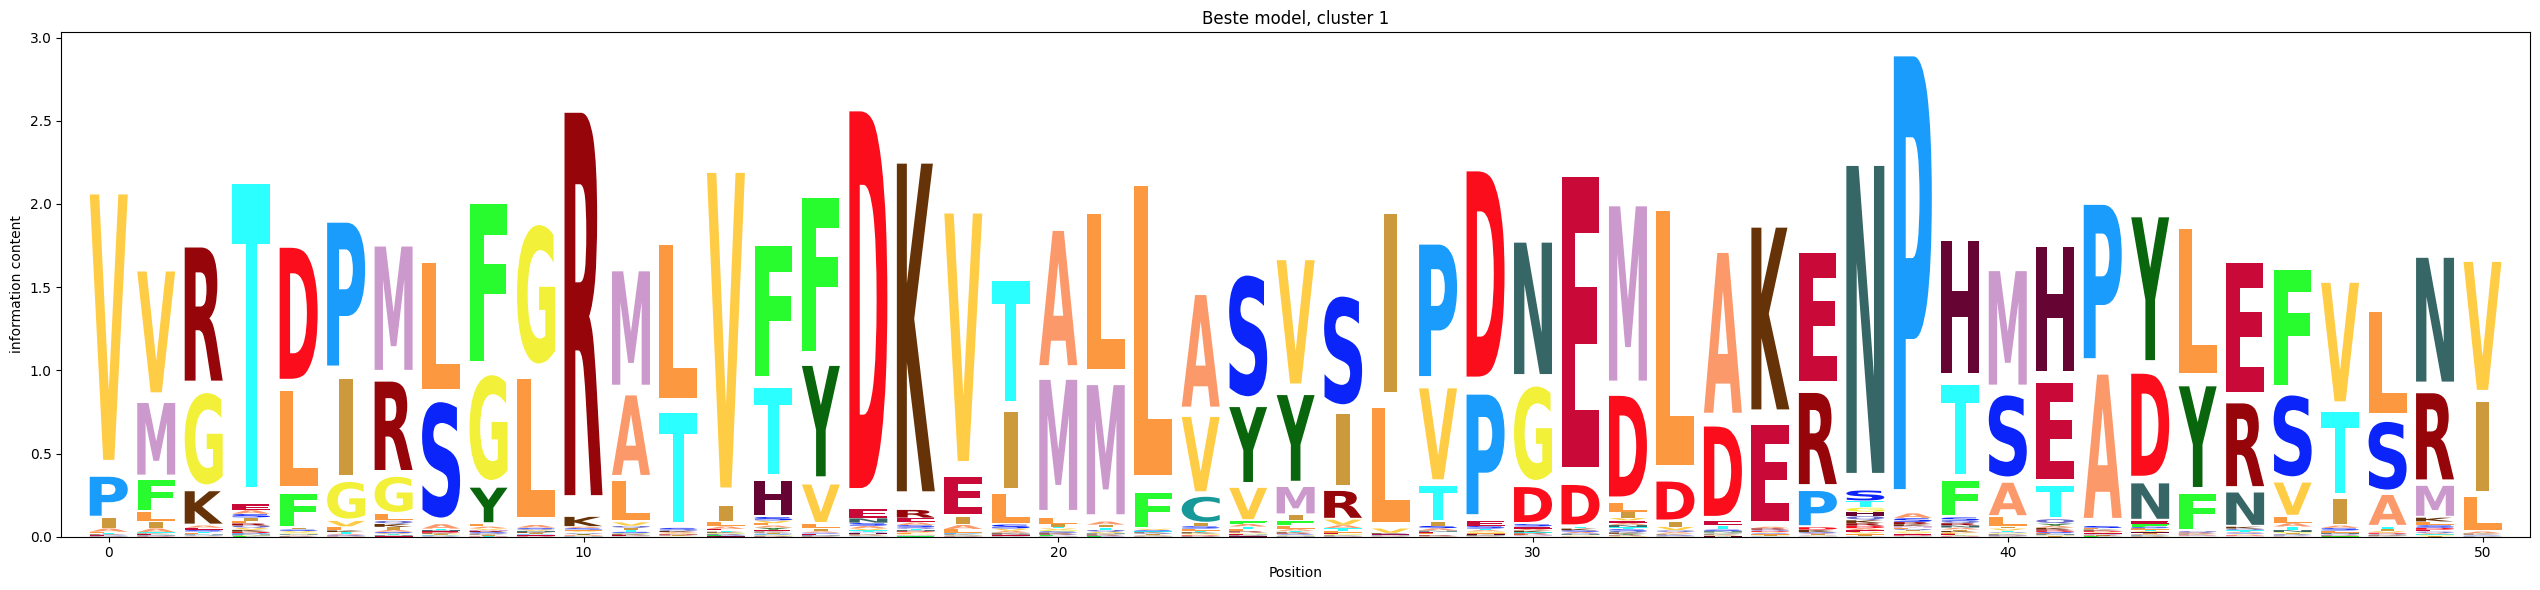

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title(f"Beste model, cluster 1")
ax.set_xlabel("Position")
ax.set_ylabel("Information content")
Visualize.plot_logo(alignment_model, alignment_model.best_model, ax, cluster_index=0)
plt.tight_layout()

In [7]:
# compute the overall SP score
fastsp_bin = "../snakeMSA/FastSP/FastSP.jar"
!java -jar {fastsp_bin} -r {ref_filename} -e test/data/star_default.fasta

Reference alignment: /home/felix/src/learnMSA/../trees/data/dev_msa/3_1000_short.fa ...
Estimated alignment: /home/felix/src/learnMSA/test/data/star_default.fasta ...
MaxLenNoGap= 58, NumSeq= 3355, LenRef= 307, LenEst= 169, Cells= 1596980
computing ...
Number of shared homologies: 169944956
Number of homologies in the reference alignment: 259073401
Number of homologies in the estimated alignment: 260797953
Number of correctly aligned columns: 0
Number of aligned columns in ref. alignment: 55
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 249 0
Number of aligned columns in est. alignment: 97
Number of singleton and (uncollapsed) insertion columns in est. alignment: 72 0
SP-Score 0.6559722277317076
Modeler 0.6516345471469249
SPFN 0.3440277722682924
SPFP 0.3483654528530751
Compression (naive) 0.5504885993485342
Compression 0.555921052631579
TC 0.0
Time to compute (seconds): 0.116


In [8]:
#compute the cluster SP-scores
cluster_ids = true_tree.get_parent_indices_by_height(0)-true_tree.num_leaves
num_clust = np.max(cluster_ids)+1

cluster_ref_seqs = []
cluster_pred_seqs = []
for j in range(num_clust):
    cluster_ref_seqs.append([])
    cluster_pred_seqs.append([])

ref_data = SequenceDataset(ref_filename)
pred_data = SequenceDataset(out_filename)

for i,j in enumerate(cluster_ids):
    ref_seq = ref_data.get_standardized_seq(i, remove_gaps=False)
    pred_seq = pred_data.get_standardized_seq(i, remove_gaps=False)
    header = ref_data.get_header(i)
    assert header == pred_data.get_header(i)
    cluster_ref_seqs[j].append((header, ref_seq))
    cluster_pred_seqs[j].append((header, pred_seq))

ref_data.close()
pred_data.close()

for j in range(num_clust):

    cluster_ref_file_name = f"tmp/{j}_ref"
    with open(cluster_ref_file_name, "w") as cluster_ref_file:
        for header, seq in cluster_ref_seqs[j]:
            cluster_ref_file.write(">"+header+"\n")
            cluster_ref_file.write(seq+"\n")

    cluster_pred_file_name = f"tmp/{j}_pred"
    with open(cluster_pred_file_name, "w") as cluster_pred_file:
        for header, seq in cluster_pred_seqs[j]:
            cluster_pred_file.write(">"+header+"\n")
            cluster_pred_file.write(seq+"\n")

    print("Cluster", j)
    print("Size: ", len(cluster_pred_seqs[j]))
    !java -jar {fastsp_bin} -r {cluster_ref_file_name} -e {cluster_pred_file_name}

Cluster 0
Size:  1392
Reference alignment: /home/felix/src/learnMSA/tmp/0_ref ...
Estimated alignment: /home/felix/src/learnMSA/tmp/0_pred ...
MaxLenNoGap= 57, NumSeq= 1392, LenRef= 307, LenEst= 169, Cells= 662592
computing ...
Number of shared homologies: 48011376
Number of homologies in the reference alignment: 48098594
Number of homologies in the estimated alignment: 48098733
Number of correctly aligned columns: 7
Number of aligned columns in ref. alignment: 50
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 103 0
Number of aligned columns in est. alignment: 74
Number of singleton and (uncollapsed) insertion columns in est. alignment: 32 0
SP-Score 0.9981866829620841
Modeler 0.9981837983133568
SPFN 0.0018133170379158736
SPFP 0.001816201686643204
Compression (naive) 0.5504885993485342
Compression 0.6928104575163399
TC 0.14
Time to compute (seconds): 0.066
Cluster 1
Size:  1358
Reference alignment: /home/felix/src/learnMSA/tmp/1_ref ...
Estimated alignment: 